In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.2f}'.format


**Início da Análise**

In [164]:
# Conectando ao banco de dados
db_path = './Dados/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [165]:
# Função para visualizar as tabelas
def consulta_simples(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

In [166]:
consulta_simples('orders', 5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [167]:
encomendas_por_dia = """
SELECT
    DATE(order_purchase_timestamp) AS dia,
    COUNT(*) AS count_pedidos
FROM orders
GROUP BY dia
"""

df = pd.read_sql_query(encomendas_por_dia, db_connection)
df.head(5)

,dia,count_pedidos
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


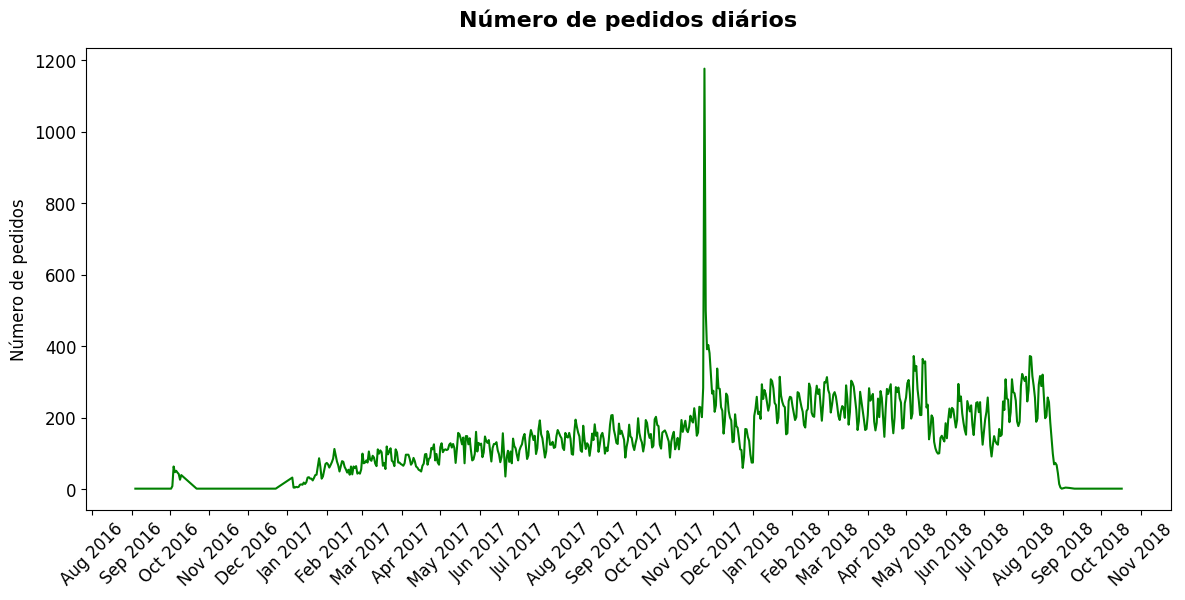

In [168]:
import matplotlib.dates as mdates

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['dia']), df['count_pedidos'], linestyle='-', color='green')
plt.ylabel('Número de pedidos')
plt.title('Número de pedidos diários', pad=15, fontsize=16, fontweight='bold', color='black')
# Ajustar os rótulos do eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

**Verificando a distribuição dos pedidos ao longo da semana e das horas do dia.**

In [169]:
encomendas_por_dia_e_hora = """
SELECT
    -- Dias da semana abreviados
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Seg'
        WHEN '2' THEN 'Ter'
        WHEN '3' THEN 'Qua'
        WHEN '4' THEN 'Qui'
        WHEN '5' THEN 'Sex'
        WHEN '6' THEN 'Sab'
        WHEN '0' THEN 'Dom'
        END AS dia_da_semana,
    -- Dias da semana como inteiro (Domingo=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS dia_da_semana_int,
    -- Hora do dia (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hora
FROM orders
"""

pd.read_sql_query(encomendas_por_dia_e_hora, db_connection)


,dia_da_semana,dia_da_semana_int,hora
0,Seg,1,10
1,Ter,2,20
2,Qua,3,8
3,Sab,6,19
4,Ter,2,21
...,...,...,...
99436,Qui,4,9
99437,Ter,2,12
99438,Dom,0,14
99439,Seg,1,21


In [170]:
# Gerando consultas SQL para contagem de pedidos por hora
contagem_pedidos_por_hora = ',\n    '.join([
    f'COUNT(CASE WHEN hora = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

pedidos_por_dia_da_semana_e_hora = f"""
WITH PedidosPorHora AS (
    {encomendas_por_dia_e_hora}
)

SELECT
    dia_da_semana,
    {contagem_pedidos_por_hora}
FROM PedidosPorHora
GROUP BY dia_da_semana_int
ORDER BY dia_da_semana_int
"""

In [171]:
print(pedidos_por_dia_da_semana_e_hora[591:])

ELECT
    dia_da_semana,
    COUNT(CASE WHEN hora = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hora = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hora = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hora = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hora = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hora = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hora = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hora = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hora = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hora = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hora = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hora = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hora = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hora = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hora = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hora = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hora = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hora = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hora = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN hora =

In [172]:
df = pd.read_sql_query(pedidos_por_dia_da_semana_e_hora, db_connection)
df = df.set_index('dia_da_semana')
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
dia_da_semana,,,,,,,,,,,,,,,,,,,,,,,,
Dom,267,141,69,44,27,27,34,105,205,349,531,721,678,723,684,716,712,797,895,899,967,889,873,607
Seg,328,134,66,36,21,22,69,160,479,783,1035,1078,971,1027,1096,1079,1094,992,928,945,1027,1118,991,717
Ter,306,158,80,28,29,24,71,223,522,864,967,1056,898,1045,1124,1047,1081,967,877,924,988,1027,965,692
Qua,397,179,81,33,33,27,93,211,517,829,1042,1062,919,1029,1050,983,1040,967,852,848,904,963,878,615
Qui,355,167,75,39,31,28,85,220,502,758,984,960,983,986,977,928,1077,909,784,826,839,840,857,551
Sex,426,216,72,49,40,36,97,206,493,768,956,990,855,1002,961,979,974,817,723,784,738,726,702,512
Sab,315,175,67,43,25,24,53,106,249,434,662,711,691,706,677,722,697,701,710,756,730,654,550,429


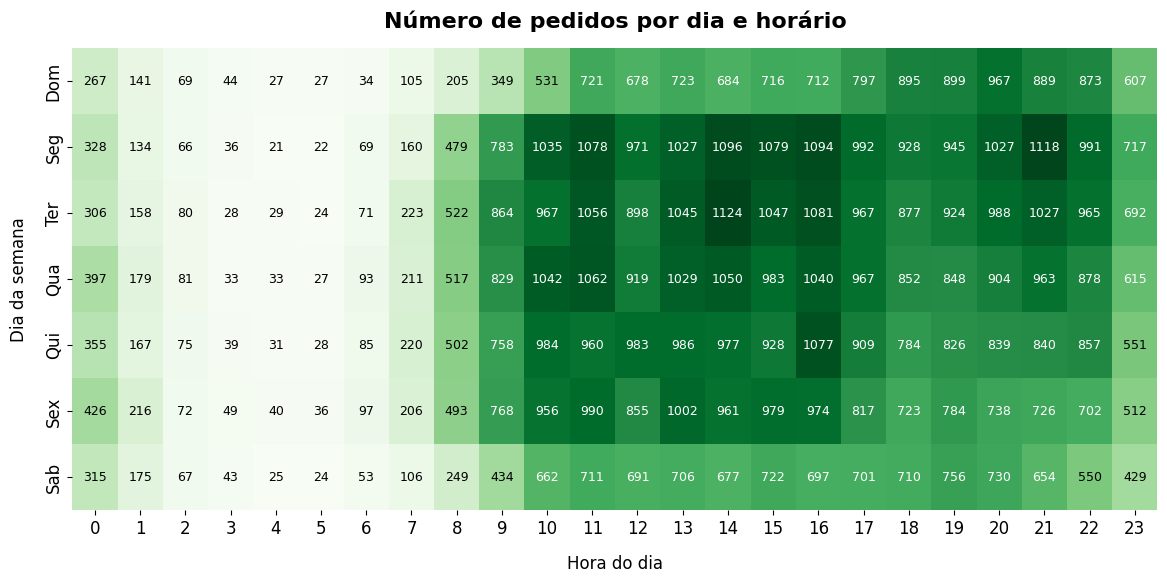

In [173]:
# Criar uma figura e um eixo com tamanho 14x6 polegadas
fig, ax = plt.subplots(figsize=(14, 6))

# Criar um mapa de calor (heatmap) usando o DataFrame df
sns.heatmap(df, cmap='Greens', cbar=False)

# Calcular a média de todas as encomendas no DataFrame
media_encomendas = df.mean().mean()

# Loop através das linhas do DataFrame
for i in range(len(df)):
    # Loop através das colunas do DataFrame
    for j in range(len(df.columns)):
        # Definir a cor do texto como branco se o valor for maior que a média, caso contrário, preto
        text_color = 'white' if df.iloc[i, j] > media_encomendas else 'black'
        # Adicionar o texto com o valor de cada célula no centro da célula
        ax.text(j + 0.5, i + 0.5, int(df.iloc[i, j]),
                color=text_color, fontsize=9, ha="center", va="center")

# Adicionar um título ao gráfico e rótulos ao eixo x e y
plt.title("Número de pedidos por dia e horário", pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel("Hora do dia", labelpad=12)
plt.ylabel("Dia da semana", labelpad=12)
plt.show()


O gráfico heatmap acima, mostra que a maioria dos pedidos foram realizados de segunda a sexta, em horário comercial, entre as 10:00h e 17:00h e de domingo a quarta-feira das 20:00h às 22:00h. Verificamos também um leve queda nas vendas por volta de meio dia.

Os picos de vendas ocorrem normalmente as segundas por volta das 14 e 21 horas, e as terças, também as 14 horas.

**Investigando a localização geográfica dos pedidos**

In [174]:
consulta_simples('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [175]:
# Gerando consultas SQL para contagem de pedidos por cidade
pedidos_por_cidade = """
SELECT 
    customer_city AS cidade_cliente,
    UPPER(customer_city) AS cidade,
    COUNT(orders.order_id) AS contagem_pedidos_cidade
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY contagem_pedidos_cidade DESC
LIMIT 10
"""

pd.read_sql_query(pedidos_por_cidade, db_connection)

,cidade_cliente,cidade,contagem_pedidos_cidade
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


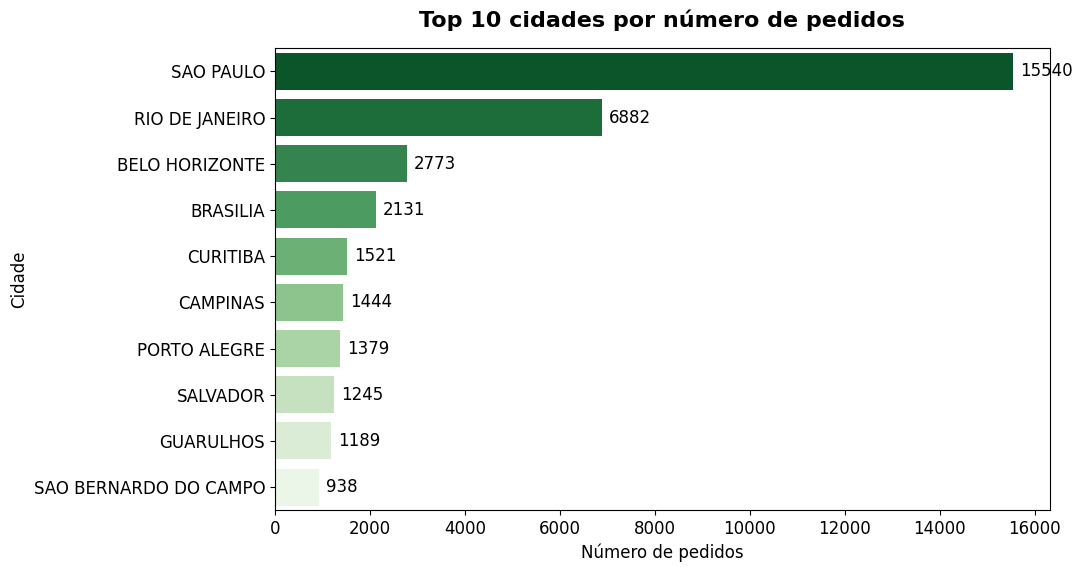

In [176]:
# Executar a consulta SQL e armazenar o resultado em um DataFrame
top_cities = pd.read_sql_query(pedidos_por_cidade, db_connection)

# Criar a figura e os eixos
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras horizontais com Seaborn
ax = sns.barplot(x='contagem_pedidos_cidade', y='cidade', data=top_cities, palette='Greens_r', orient='h')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 cidades por número de pedidos', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')

# Adicionar os valores no final das barras
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                va='center', xytext=(5, 0), textcoords='offset points')

# Exibir o gráfico
plt.show()

**Investigando os preços, valor médio do ticket e outras questões relacionadas a precificação.**

In [177]:
consulta_simples('order_items', 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [178]:
# Consulta SQL para obter os preços dos itens e o valor do frete
consulta_simples('order_items', 5).iloc[:, 5:]

,price,freight_value
0,58.90,13.29
1,239.90,19.93
2,199.00,17.87
3,12.99,12.79
4,199.90,18.14


In [179]:
# Extrai estatísticas de preços através de subconsulta SQL
estatisticas_preco_pedido = """
SELECT
    MIN(preco_pedido) AS preco_min_pedido,
    ROUND(AVG(preco_pedido), 2) AS preco_medio_pedido,
    MAX(preco_pedido) AS preco_max_pedido
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS preco_pedido
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(estatisticas_preco_pedido, db_connection)

,preco_min_pedido,preco_medio_pedido,preco_max_pedido
0,9.59,160.58,13664.08


Ao analisarmos as estatísticas básicas dos preços, e compararmos o preço médio dos pedidos (R$ 160,58), o preço mínimo (R$ 9,59) e máximo (R$ 13.664,08), verificamos um desbalanceamento na distribuição dos valores através do que parece ser um ou mais outliers. O que resulta numa distribuição de cauda longa a direita que precisa ser investigada.

In [180]:
# Consulta SQL para obter o preço do item e o valor do frete
preco_produto_e_frete = """
SELECT
    orders.order_id,
    SUM(price) AS preco_produto,
    SUM(freight_value) AS custo_frete
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(preco_produto_e_frete, db_connection)
df

,order_id,preco_produto,custo_frete
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


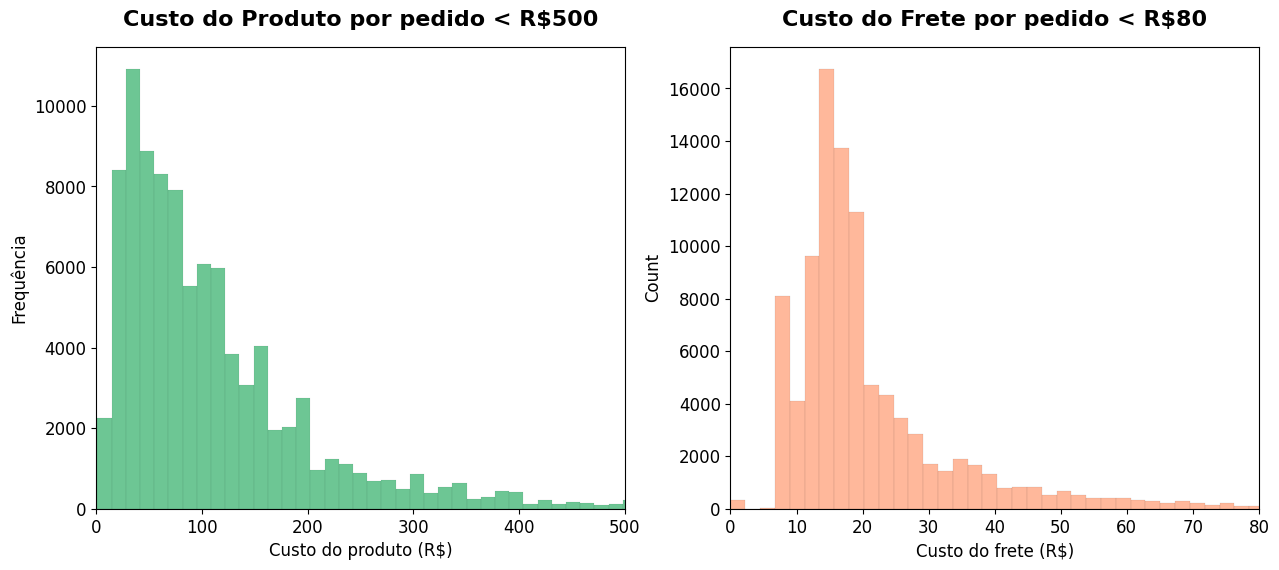

In [181]:
# Gráfico de dispersão de preço e frete
plt.figure(figsize=(15, 6))

# Gráfico do custo do produto
plt.subplot(1, 2, 1)
sns.histplot(df['preco_produto'], bins=1000, color='#3CB371', kde=False)
plt.title('Custo do Produto por pedido < R$500', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Custo do produto (R$)')
plt.ylabel('Frequência')
plt.xlim([0, 500])

# Gráfico do custo de frete
plt.subplot(1, 2, 2)
sns.histplot(df['custo_frete'], bins=800, color='#FFA07A', kde=False)
plt.title('Custo do Frete por pedido < R$80', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Custo do frete (R$)')
plt.xlim([0, 80])

# Mostrar os gráficos
plt.show()

Ao analisarmos os gráficos de histograma de preços e fretes, podemos concluir que a maior parte dos pedidos custam entre 15 e 150 reais e que o frete, tem a maioria dos seus valores entre 8 e 20 reais.

In [182]:
# Consulta SQL para obter os 10 produtos mais vendidos
consulta_simples('products', 10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,1000.00,30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.00,745.00,1.00,200.00,38.00,5.00,11.00
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.00,1272.00,4.00,18350.00,70.00,24.00,44.00
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.00,184.00,2.00,900.00,40.00,8.00,40.00
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.00,163.00,1.00,400.00,27.00,13.00,17.00
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.00,1156.00,1.00,600.00,17.00,10.00,12.00


In [183]:
ranking_categorias = """
SELECT
    product_category_name AS categoria,
    SUM(price) AS vendas,
    RANK() OVER (ORDER BY SUM(price) DESC) AS classificacao
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
WHERE order_status = 'delivered'
GROUP BY product_category_name
"""

pd.read_sql_query(ranking_categorias, db_connection)

,categoria,vendas,classificacao
0,beleza_saude,1233131.72,1
1,relogios_presentes,1166176.98,2
2,cama_mesa_banho,1023434.76,3
3,esporte_lazer,954852.55,4
4,informatica_acessorios,888724.61,5
...,...,...,...
69,flores,1110.04,70
70,casa_conforto_2,760.27,71
71,cds_dvds_musicais,730.00,72
72,fashion_roupa_infanto_juvenil,519.95,73


In [184]:
resumo_vendas_por_categoria = f"""
WITH CategoriasClassificadas AS (
    {ranking_categorias}
)
-- Top 15 categorias por vendas
SELECT
    categoria,
    vendas
FROM CategoriasClassificadas
WHERE classificacao <= 15
-- Outras categorias, agregadas
UNION ALL
SELECT
    'Outras categorias' AS categoria,
    SUM(vendas) AS vendas
FROM CategoriasClassificadas
WHERE classificacao > 15
"""

df = pd.read_sql_query(resumo_vendas_por_categoria, db_connection)
df

,categoria,vendas
0,beleza_saude,1233131.72
1,relogios_presentes,1166176.98
2,cama_mesa_banho,1023434.76
3,esporte_lazer,954852.55
4,informatica_acessorios,888724.61
...,...,...
11,bebes,400421.84
12,perfumaria,390144.65
13,telefonia,309860.23
14,moveis_escritorio,268154.31


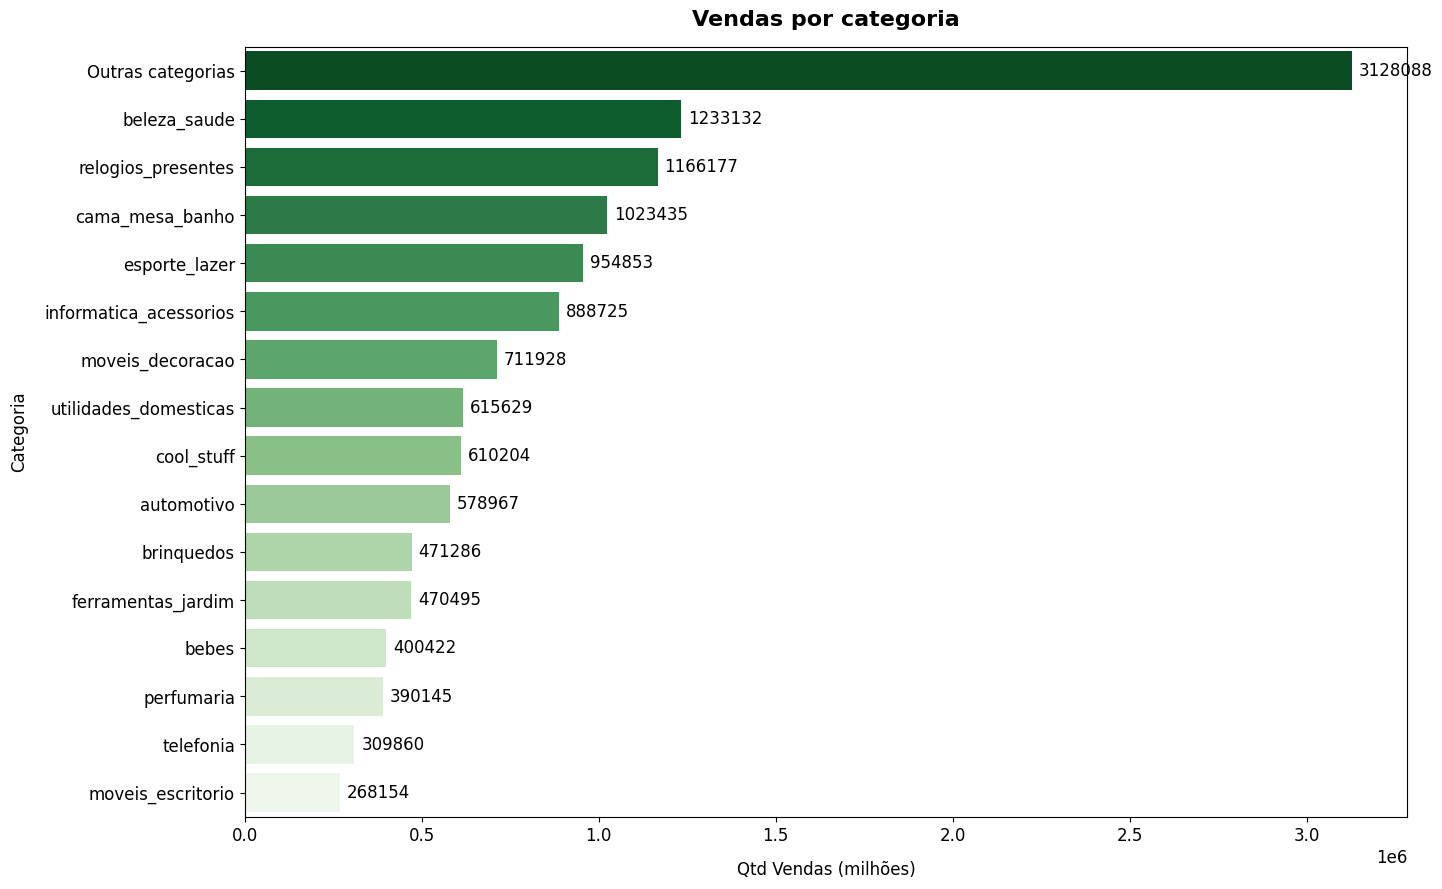

In [186]:
# Ordenar o DataFrame por vendas para um gráfico mais organizado
df_sorted = df.sort_values(by='vendas', ascending=False)

# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Criar o gráfico de barras horizontais
ax = sns.barplot(x='vendas', y='categoria', data=df_sorted, palette='Greens_r')

# Adicionar o título ao gráfico
plt.title('Vendas por categoria', pad=15, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Qtd Vendas (milhões)', labelpad=12)
plt.ylabel('Categoria', labelpad=12)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                va='center', xytext=(5, 0), textcoords='offset points')
    
plt.show()